# Setup

In [1]:
# import packages
import numpy as np
import os
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
from tqdm import tqdm

In [2]:
## define path to input datasets (tidy format)
path_to_recog = '/home/jefan/neurosketch_compmem/neurosketch_voxelmat_freesurfer_recog'
path_to_draw = '/home/jefan/neurosketch_compmem/neurosketch_voxelmat_freesurfer_drawing'
path_to_recog = '/home/jgunn/neurosketch/recmatrices'
path_to_draw = '/home/jgunn/neurosketch/drawmatrices' 
roi_list = np.array(["V1", "V2", "LOC", "IT", "fusiform", "parahippo",  "PRC",  "ento", "hipp", 'mOFC', 'IFG', 'rostMFG', 'caudMFG', 'precentral', 'SMG', 'STG'])
roi_formatted = np.array(["V1", "V2", "LOC", "IT", "fusiform", "para\nhippo",  "PRC",  "ento", "hipp", 'mOFC', 'IFG', 'rost\nMFG', 'caud\nMFG', 'pre\ncentral', 'SMG', 'STG'])

roi_formatted = np.array(["V1", "V2", "LOC", "IT", "fusiform", "para\nhippo",  "PRC",  "ento", "hipp", 'mOFC'])
roi_list = np.array(["V1", "V2", "LOC", "IT", "fusiform", "parahippo",  "PRC",  "ento", "hipp", 'mOFC'])
## get raw file list for recognition runs
RECOG_METAS = sorted([i for i in os.listdir(path_to_recog) if i.split('.')[-1]=='csv'])
RECOG_FEATS = sorted([i for i in os.listdir(path_to_recog) if i.split('.')[-1]=='npy'])
RECOG_SUBS = np.array([i.split('_')[0] for i in RECOG_FEATS])

recog_sub_list = np.unique(RECOG_SUBS)

def preprocess_recog(RECOG_METAS, RECOG_FEATS):
    M = [i for i in RECOG_METAS if len(i.split('.')[0].split('_'))==4]
    F = [i for i in RECOG_FEATS if len(i.split('.')[0].split('_'))==4]
    return M,F

RECOG_METAS, RECOG_FEATS = preprocess_recog(RECOG_METAS, RECOG_FEATS)

In [3]:
## get raw file list for drawing runs
DRAW_METAS = sorted([i for i in os.listdir(path_to_draw) if i.split('.')[-1]=='csv'])
DRAW_FEATS = sorted([i for i in os.listdir(path_to_draw) if i.split('.')[-1]=='npy'])
DRAW_SUBS = np.array([i.split('_')[0] for i in DRAW_FEATS])
draw_sub_list = np.unique(DRAW_SUBS)

In [4]:
## get subject ID's that have complete datasets from all phases of experiment
sub_list = np.intersect1d(recog_sub_list,draw_sub_list)
#sub_list = [s for s in sub_list if s != '1207162']
print('Number of subs: {}'.format(len(sub_list)))

Number of subs: 31


In [5]:
## filter file list so only contains the sessions that have full datasets
def extract_good_sessions(DRAW_METAS,DRAW_FEATS,RECOG_METAS,RECOG_FEATS):
    _DRAW_METAS = [i for i in DRAW_METAS if i.split('_')[1] in sub_list]
    _DRAW_FEATS = [i for i in DRAW_FEATS if i.split('_')[0] in sub_list]
    _RECOG_METAS = [i for i in RECOG_METAS if i.split('_')[1] in sub_list]
    _RECOG_FEATS = [i for i in RECOG_FEATS if i.split('_')[0] in sub_list]
    return _DRAW_METAS, _DRAW_FEATS, _RECOG_METAS, _RECOG_FEATS

DRAW_METAS,DRAW_FEATS,RECOG_METAS,RECOG_FEATS =  \
extract_good_sessions(DRAW_METAS,DRAW_FEATS,RECOG_METAS,RECOG_FEATS)

RECOG_SUBS = np.array([i.split('_')[0]+'_neurosketch' for i in RECOG_FEATS])
RECOG_ROIS = np.array([i.split('_')[1] for i in RECOG_FEATS])

DRAW_SUBS = np.array([i.split('_')[0]+'_neurosketch' for i in DRAW_FEATS])
DRAW_ROIS = np.array([i.split('_')[1] for i in DRAW_FEATS])

In [6]:
#### Helper data loader functions
def cleanup_df(df):    
    surplus = [i for i in df.columns if 'Unnamed' in i]
    df = df.drop(surplus,axis=1)
    return df

def flatten(x):
    return [item for sublist in x for item in sublist]

def bootstrapCI(x,estimator,nIter):
    u = []
    for i in tqdm(np.arange(nIter)):
        inds = np.random.RandomState(i).choice(len(x),len(x))
        boot = x[inds]
        u.append(estimator(boot))
        
    p1 = len([i for i in u if i<0])/len(u) * 2
    p2 = len([i for i in u if i>0])/len(u) * 2
    p = np.min([p1,p2])
    U = np.mean(u)
    lb = np.percentile(u,2.5)
    ub = np.percentile(u,97.5)    
    return U,lb,ub,p

def corrbootstrapCI(x,y,nIter):
    '''
    input: x is an array
    '''
    u = []
    for i in np.arange(nIter):
        inds = np.random.RandomState(i).choice(len(x),len(x))
        bootx = x[inds]
        booty = y[inds]
        u.append(stats.pearsonr(bootx,booty)[0])
        
    p1 = len([i for i in u if i<0])/len(u) * 2
    p2 = len([i for i in u if i>0])/len(u) * 2
    p = np.min([p1,p2])
    U = np.mean(u)
    lb = np.percentile(u,2.5)
    ub = np.percentile(u,97.5)    
    return U,lb,ub,p

def get_trained_objs(DM):
    return np.unique(DM.label.values)

def get_prob_timecourse(iv,DM,version='4way'):
    trained_objs = np.unique(DM.label.values)
    control_objs = [i for i in ['bed','bench','chair','table'] if i not in trained_objs]    
    
    if version=='4way':
        t1 = trained_objs[0]
        t2 = trained_objs[1]
        c1 = control_objs[0]
        c2 = control_objs[1]
        target = np.vstack((DM[DM.label==t1].groupby(iv)['t1_prob'].mean().values,
                       DM[DM.label==t2].groupby(iv)['t2_prob'].mean().values)).mean(0) ## target timecourse
        foil = np.vstack((DM[DM.label==t1].groupby(iv)['t2_prob'].mean().values,
                       DM[DM.label==t2].groupby(iv)['t1_prob'].mean().values)).mean(0) ## foil timecourse
        control = np.vstack((DM[DM.label==t1].groupby(iv)['c1_prob'].mean().values,
                            DM[DM.label==t1].groupby(iv)['c2_prob'].mean().values,
                            DM[DM.label==t2].groupby(iv)['c1_prob'].mean().values,
                            DM[DM.label==t2].groupby(iv)['c2_prob'].mean().values)).mean(0) ## control timecourse    
    elif version=='3way':
        t1 = trained_objs[0]
        t2 = trained_objs[1]
        target = np.vstack((DM[DM.label==t1].groupby(iv)['t1_prob'].mean().values,
                       DM[DM.label==t2].groupby(iv)['t2_prob'].mean().values)).mean(0) ## target timecourse; mean is taken over what?
        foil = np.vstack((DM[DM.label==t1].groupby(iv)['t2_prob'].mean().values,
                       DM[DM.label==t2].groupby(iv)['t1_prob'].mean().values)).mean(0) ## foil timecourse
        control = np.vstack((DM[DM.label==t1].groupby(iv)['c_prob'].mean().values,
                            DM[DM.label==t2].groupby(iv)['c_prob'].mean().values)).mean(0) ## control timecourse
        
    elif version=='2way':
        t1 = trained_objs[0]
        t2 = trained_objs[1]
        target = np.vstack((DM[DM.label==t1].groupby(iv)['t1_prob'].mean().values,
                       DM[DM.label==t2].groupby(iv)['t2_prob'].mean().values)).mean(0) ## target timecourse; mean is taken over what?
        foil = np.vstack((DM[DM.label==t1].groupby(iv)['t2_prob'].mean().values,
                       DM[DM.label==t2].groupby(iv)['t1_prob'].mean().values)).mean(0) ## foil timecourse
        
        control = np.zeros(len(foil)) 
        
    return target, foil, control

In [7]:
version = '4way'
tag = 'raw'
ALLDM = pd.read_csv('./logistic_timeseries_drawing_neural_{}_{}.csv'.format(version,tag))
#ALLDM = pd.read_csv('./formatted_partial_sketch.csv')
ALLDM = cleanup_df(ALLDM)

# Implementation

Here's the plan. For each ROI...
1. Generate a subject-by-trial_num matrix where each cell is either `t`, `f`, or `t-f` from the output of `analysis_helpers.get_prob_timecourse` for the associated trial and subject (and roi) pairing. 
2. Generate a subject_num length vector consisting of each subject's pre-post change measure in the same order as they are in the matrix.
3. The vector defined by taking the `stats.pearsonr()` between each column of the subject-by-trial_num matrix and the prepost change vector is the time course we're looking to understand for this ROI.

In [8]:
# Here's the plan. For each ROI...
# 1. Generate a subject-by-iv matrix where each cell is either `t`, `f`, or `t-f` from the output of `analysis_helpers.get_prob_timecourse` for the associated trial and subject (and roi) pairing. 
# 2. Generate a subject_num length vector consisting of each subject's pre-post change measure in the same order as they are in the matrix.
# 3. The vector defined by taking the `stats.pearsonr()` between each column of the subject-by-trial_num matrix and the prepost change vector is the time course we're looking to understand for this ROI.

subs = np.unique(ALLDM.subj.values)
prepost = pd.read_csv('neural_changes_by_surfroi_and_subject.csv')
variants = ['t', 'f','t-f']#['t', 'f', 't-f', 'c']
ivs = ['trial_num']#['run_num','trial_num']#,'time_point']
#this_iv = 'run_num'

for this_iv in ivs:
    for variant in variants:
        for this_roi in roi_list:

            # 1. Generate a subject-by-trial_num matrix where each cell is either `t`, `f`, or `t-f` from the 
            # output of `analysis_helpers.get_prob_timecourse` for the associated trial and subject (and roi) pairing. 
            scores = []

            for sub in subs:
                inds = (ALLDM['roi']==this_roi) & (ALLDM['subj']==sub)
                t,f,c = get_prob_timecourse(this_iv,ALLDM[inds])

                if variant == 't':
                    score = t
                elif variant == 'f':
                    score = f
                elif variant == 'c':
                    score = c
                else:
                    score = t-f

                if len(scores) == 0:
                    scores = score
                else:
                    scores = np.vstack((scores, score))

            # 2. Generate a subject_num length vector consisting of each subject's pre-post change measure 
            # in the same order as they are in the matrix.
            #recog = prepost['tradiff_{}'.format(this_roi)].values-prepost['condiff_{}'.format(this_roi)].values
            recog = prepost['trained_{}'.format(this_roi)].values-prepost['control_{}'.format(this_roi)].values
            
            # 3. The vector defined by taking the `stats.pearsonr()` between each column of the subject-by-trial_num matrix
            # and the prepost change vector is the time course we're looking to understand for this ROI.
            corcourse = [stats.pearsonr(scores[:,i],recog)[0] for i in range(np.shape(scores)[1])]
            #corcourse = [np.mean(scores[:,i]) for i in range(np.shape(scores)[1])]
            
            #r,p = stats.pearsonr(np.arange(np.shape(scores)[1]),corcourse)
            
            bootstrap = [corrbootstrapCI(scores[:,i],recog, 3000) for i in range(np.shape(scores)[1])]
            lesserror, pluserror = [b[1] for b in bootstrap], [b[2] for b in bootstrap]

            fig = plt.figure(figsize=(8,4))
            plt.plot(corcourse, 'ro', label='data')
            #sns.regplot(x=np.arange(len(corcourse)), y=np.array(corcourse))
            plt.axhline(y=0.0,linestyle='dashed')
            plt.ylim((-.6,.6))
            plt.ylabel('corr({}, prepost_difference)'.format(variant))
            plt.xlabel(this_iv)
            plt.title('ROI: {}'.format(this_roi))
            plt.fill_between(np.arange(len(corcourse)), lesserror,pluserror, alpha=.2)
            
            if not os.path.exists('./plots/roi/drawrecogcourse'):
                os.makedirs('./plots/roi/drawrecogcourse')
            plt.tight_layout()
            #plt.savefig('./plots/roi/drawrecogcourse/draw_recog_course_{}_{}_{}.png'.format(this_roi,this_iv,variant))
            plt.savefig('./plots/roi/drawrecogcourse/{}_{}.png'.format(this_roi,variant))
            plt.close(fig)
            #plt.show()

Let's try a variant that plots t and f correlations with prepost separately/on the same graph.

In [25]:
subs = np.unique(ALLDM.subj.values)
prepost = pd.read_csv('neural_changes_by_surfroi_and_subject.csv')
ivs = ['run_num','trial_num']#,'time_point']
#this_iv = 'run_num'

for this_iv in ivs:
    for this_roi in roi_list:

        # 1. Generate a subject-by-trial_num matrix where each cell is either `t`, `f`, or `t-f` from the 
        # output of `analysis_helpers.get_prob_timecourse` for the associated trial and subject (and roi) pairing. 
        T = []
        F = []
        C = []

        for sub in subs:
            inds = (ALLDM['roi']==this_roi) & (ALLDM['subj']==sub)
            t,f,c = get_prob_timecourse(this_iv,ALLDM[inds])
            num_ivs = len(t)

            if len(T) == 0:
                T = t
                F = f
                C = c
                DTF = t-f
            else:
                T = np.vstack((T,t))
                F = np.vstack((F,f))
                C = np.vstack((C,c))
                DTF = np.vstack((DTF,t-f))

        # 2. Generate a subject_num length vector consisting of each subject's pre-post change measure 
        # in the same order as they are in the matrix.
        recog = prepost['tradiff_{}'.format(this_roi)].values-prepost['condiff_{}'.format(this_roi)].values
        recog = prepost['trained_{}'.format(this_roi)].values-prepost['control_{}'.format(this_roi)].values

        # 3. The vector defined by taking the `stats.pearsonr()` between each column of the subject-by-trial_num matrix
        # and the prepost change vector is the time course we're looking to understand for this ROI.

        fig = plt.figure(figsize=(8,4))

        corcourse = [stats.pearsonr(T[:,i],recog)[0] for i in range(num_ivs)]
        #corcourse = [np.mean(T[:,i]) for i in range(num_ivs)]
        meanT = np.mean(np.array(corcourse))
        r,p = stats.pearsonr(np.arange(num_ivs),corcourse)
        plt.plot(corcourse, 'ro', label='target')
        plt.plot(np.arange(num_ivs), np.poly1d(np.polyfit(np.arange(num_ivs), corcourse, 1))(np.unique(np.arange(num_ivs))), 'r')

        corcourse = [stats.pearsonr(F[:,i],recog)[0] for i in range(num_ivs)]
        #corcourse = [np.mean(F[:,i]) for i in range(num_ivs)]
        meanF = np.mean(np.array(corcourse))
        r,p = stats.pearsonr(np.arange(num_ivs),corcourse)
        plt.plot(corcourse, 'cv', label='competitor')
        plt.plot(np.arange(num_ivs), np.poly1d(np.polyfit(np.arange(num_ivs), corcourse, 1))(np.unique(np.arange(num_ivs))), 'c')

        plt.ylabel('corr({}, prepost_difference)'.format(variant))
        plt.xlabel(this_iv)
        plt.title('ROI: {}  mean(t): {}  mean(f): {}'.format(this_roi, meanT, meanF))
        plt.legend()

        if not os.path.exists('./plots/roi/drawrecogcourse'):
            os.makedirs('./plots/roi/drawrecogcourse')
        plt.tight_layout()
        plt.savefig('./plots/roi/drawrecogcourse/draw_recog_course_{}_{}.pdf'.format(this_roi, this_iv))
        plt.close(fig)

Let's try redo-ing the original draw_contrast vs prepost differentiation analysis focusing the target and competitor scores.

In [22]:
sub_tf = []
sub_tc = []
sub_fc = []
roi = []
lookup = dict(zip(['trial_num','run_num','time_point'],['repetition','run','TR']))

subs = np.unique(ALLDM.subj.values)
ivs = ['trial_num'] ## other options 'run_num','trial_num',

## do you want to render the CONDITION-wise plots -- trained vs. foil vs control
## or the DIFFERENCE plots -- trained - foil vs foil - control?
render_cond = 0

for this_iv in ivs:
    for this_roi in roi_list:

        T = []
        F = []
        C = []
        Sub = []
        for sub in subs:
            inds =(ALLDM['roi']==this_roi) & (ALLDM['subj']==sub) 
            t,f,c = get_prob_timecourse(this_iv,ALLDM[inds],version=version)
#             t,f,c = get_prob_timecourse_alt(this_iv,ALLDM[inds])                    
            if len(T)==0:
                T = t
                F = f
                C = c
                DTF = t-f               
                DTC = t
                DFC = f
            else:
                T = np.hstack((T,t))
                F = np.hstack((F,f))        
                C = np.hstack((C,c)) 
                DTF = np.hstack((DTF,t-f))                
                DTC = np.hstack((DTC,t))
                DFC = np.hstack((DFC,f))
            Sub.append([sub]*len(t))   
          
        ## make longform version of dataframe to use in tsplot (difference btw conditions)                    
        Trial = np.tile(np.arange(len(t)),len(subs)*3)
        Condition = np.repeat(['target-foil','target','foil'],len(T))
        Sub = np.tile(np.array(flatten(Sub)),3)
        Prob = np.hstack((DTF,DTC,DFC))        
        assert len(Trial)==len(Condition)
        assert len(Sub)==len(Prob)
        assert len(Condition)==len(Sub)
        x = pd.DataFrame([Prob,Trial,Condition,Sub])
        x = x.transpose()
        x.columns = ['probability',lookup[this_iv],'condition','sub']
        
        for this_sub in subs:
            sub_tf.append(x[(x['condition']=='target-foil') & (x['sub']==this_sub)]['probability'].mean())
            sub_tc.append(x[(x['condition']=='target') & (x['sub']==this_sub)]['probability'].mean())  
            sub_fc.append(x[(x['condition']=='foil') & (x['sub']==this_sub)]['probability'].mean()) 
            roi.append(this_roi)
            
## make dataframe with subject-level difference scores
d = pd.DataFrame([sub_tf,sub_tc,sub_fc,roi])
d = d.transpose()
d.columns = ['target-foil','target','foil','roi']
d = d.astype({'target-foil':'float64','target':'float64','foil':'float64'})

In [23]:
prepost = pd.read_csv('neural_changes_by_surfroi_and_subject.csv')

## make dataframe to relate drawing contrast to recognition differentiation
roi_list = ['V1', 'V2', 'LOC', 'IT', 'fusiform', 'parahippo', 'PRC', 'ento','hipp', 'mOFC']

for spec in ['target-foil']:
    for this_roi in roi_list:
    #     draw = d[d['roi']==this_roi]['target-control'].values - d[d['roi']==this_roi]['foil-control'].values
        draw = d[d['roi']==this_roi][spec].values
        recog = prepost['tradiff_{}'.format(this_roi)].values-prepost['condiff_{}'.format(this_roi)].values
        recog = prepost['trained_{}'.format(this_roi)].values-prepost['control_{}'.format(this_roi)].values

        z = pd.DataFrame([draw,recog])
        z = z.transpose()
        z.columns=['draw','recog']

        ## plot 
        fig = plt.figure(figsize=(6,6))
        sns.set_context('poster')
        sns.regplot(x="draw",
                    y ="recog",
                    data=z)
        r,p = stats.pearsonr(draw,recog)
        plt.title('ROI: {}  r={}  p={}'.format(this_roi,np.round(r,5),np.round(p,5)))
        plt.xlabel('drawing: {}'.format(spec[:spec.find('-')]))
        plt.ylabel('recog: post-pre differentiation')
        if not os.path.exists('./plots/roi/drawrecog'):
            os.makedirs('./plots/roi/drawrecog')
        plt.tight_layout()
        plt.savefig('./plots/roi/drawrecog/draw_recog_scatter_{}_{}.pdf'.format(this_roi, spec))
        plt.close(fig)    

# Follow Up: Bar Graph Summaries

In [8]:
# parameters
logged = True
anchored = False
takeDiffDifference = True
clfmeasure = 'contrast' # one of ['target', 'foil', 'contrast']
comparison = 'regression' # one of ['correlation', 'regression', 'itemeffects']
roi_list = np.array(["V1", "V2", "LOC", "IT", "fusiform", "parahippo",  "PRC",  "ento", "hipp", 'mOFC'])
roi_formatted = np.array(["V1", "V2", "LOC", "IT", "fusiform", "para\nhippo",  "PRC",  "ento", "hipp", 'mOFC'])

preprocessing...

In [11]:
# first we want to create a dataframe that seaborn can easily bootstrap by
# we want an subject by ROI dataframe, where each entry has the subject's get_prob_timecourse() output and prepost score for the associated ROI.

version = '4way'
ALLDM = pd.read_csv('./logistic_timeseries_drawing_neural_{}_{}.csv'.format(version,'logged' if logged else 'raw'))
ALLDM = cleanup_df(ALLDM)

subs = np.unique(ALLDM.subj.values)
prepost = pd.read_csv('neural_changes_by_surfroi_and_subject.csv')
this_iv = 'trial_num'

columns = []
for this_roi in roi_list:
    scores = [get_prob_timecourse(this_iv,ALLDM[(ALLDM['roi']==this_roi) & (ALLDM['subj']==sub)]) for sub in subs]
    objs = [str(np.unique(ALLDM[(ALLDM['subj']==sub)].label.values)) for sub in subs]
    if anchored:
        recog = prepost['trained_{}'.format(this_roi)].values
        recog -= prepost['control_{}'.format(this_roi)].values if takeDiffDifference else 0
    else:
        recog = prepost['tradiff_{}'.format(this_roi)].values
        recog -= prepost['condiff_{}'.format(this_roi)].values if takeDiffDifference else 0
        
    columns.append([{'clf':scores[i], 'diff':recog[i], 'objs':objs[i]} for i in range(len(scores))])
bardf = pd.DataFrame(columns).transpose()
bardf.columns = roi_formatted

In [12]:
# helper functions
def clfBySub(subdata):
    if clfmeasure == 'contrast':
        return [sub[0]-sub[1] for sub in subdata]
    elif clfmeasure == 'target':
        return [sub[0] for sub in subdata]
    elif clfmeasure == 'foil':
        return [sub[1] for sub in subdata]
    else:
        return [sub[2] for sub in subdata]
    
def prepReg(clfscores, diffscores, objs):
    regdf = pd.DataFrame([clfscores, diffscores, objs]).transpose()
    regdf.columns = ['selectivity', 'diff', 'objs']
    regdf['selectivity'] = regdf['selectivity'].astype(float)
    regdf['diff'] = regdf['diff'].astype(float)
    regdf['objs'] = regdf['objs'].astype('category')
    return smf.ols(formula='diff ~ selectivity * objs', data = regdf).fit()

mean overall

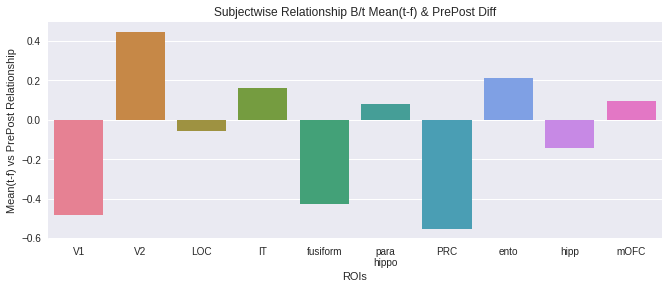

In [32]:
# first let's look at the mean draw_contrast score for each subject versus each subject's prepost differentiation measure. 

# define the estimator
# find the correlation between the vector of each subject's draw_contrast scores and that of each subject's differentiation scores
    
def scoreVSdiff(subdata):
    clfscores = [np.mean(c) for c in clfBySub([s['clf'] for s in subdata])]
    diffscores = [sub['diff'] for sub in subdata]
    return stats.pearsonr(clfscores, diffscores)[0]

def controlled_scoreVSdiff(subdata):
    clfscores = [np.mean(c) for c in clfBySub([s['clf'] for s in subdata])]
    diffscores = [sub['diff'] for sub in subdata]
    objs = [sub['objs'] for sub in subdata]
    reg = prepReg(clfscores, diffscores, objs)
    return reg.params[len(np.unique(objs))]

def covariate_scoreVSdiff(subdata):
    clfscores = [np.mean(c) for c in clfBySub([s['clf'] for s in subdata])]
    diffscores = [sub['diff'] for sub in subdata]
    objs = [sub['objs'] for sub in subdata]
    reg = prepReg(clfscores, diffscores, objs)
    A = np.identity(len(reg.params))
    InteractionTest = A[len(np.unique(objs))+1:,:]
    return reg.f_test(InteractionTest).pvalue

functionmap = {'correlation': scoreVSdiff, 'regression': controlled_scoreVSdiff, 'itemeffects': covariate_scoreVSdiff}

# derive from bardf the df we want to plot and the error bars we want
meandf = pd.DataFrame([functionmap[comparison](np.array(bardf)[:,i]) for i in range(len(roi_list))]).transpose()
meandf.columns = roi_formatted
#error = [bootstrapCI(np.array(bardf)[:,i],functionmap[comparison], 1000)[1:3] for i in range(len(roi_list))]

plt.figure(figsize=(11,4))
sns.barplot(data=meandf,palette='husl',ci=None)
plt.xlabel('ROIs')
plt.title('Subjectwise Relationship B/t Mean(t-f) & PrePost Diff') # 'Significance of Iteraction Term for (Diff ~ Mean(t-f) * object_assignment)'
plt.ylabel('Mean(t-f) vs PrePost Relationship') # 'f-test p-value'
for i in range(len(roi_list)):
    pass
    #plt.vlines(i, error[i][0], error[i][1])
plt.show()

slope of correlations

  0%|          | 1/1000 [00:00<02:48,  5.91it/s]

(-0.62911638083818888, 0.036372105854620286)


  0%|          | 1/1000 [00:00<02:46,  6.00it/s]

(-0.49131584308028836, 0.018210507978188014)


  0%|          | 1/1000 [00:00<02:52,  5.79it/s]

(-0.033015534577140654, 0.020583061161431854)


  0%|          | 1/1000 [00:00<02:46,  6.00it/s]

(-0.033331148115875758, 0.0047197481972441344)


  0%|          | 1/1000 [00:00<02:48,  5.92it/s]

(-0.052333016954717891, 0.1616657939651267)


  0%|          | 1/1000 [00:00<03:03,  5.45it/s]

(-0.69763085120458956, 1.7579613553129527)


  0%|          | 1/1000 [00:00<02:47,  5.95it/s]

(-0.22445686855848324, 0.0086629002335341047)


  0%|          | 1/1000 [00:00<02:46,  6.00it/s]

(-0.11391402321050183, 0.060376990320347337)


  0%|          | 1/1000 [00:00<02:45,  6.03it/s]

(-0.20933099470720248, 0.031994128830238215)


100%|██████████| 1000/1000 [02:49<00:00,  5.89it/s]

(-0.074494487105500537, 0.012068779778027941)


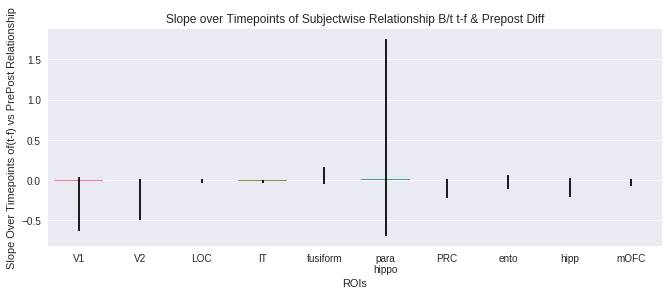

In [12]:
from scipy.stats import linregress

# second, instead of taking the overall mean draw_contrast score and relating that with differentiation, 
# get the draw_contrast score for each timepoint and relate those against differentiation
# the slope of all 20 or whatever correlations is what we graph

# define the estimator
def slope_scoreVSdiff(subdata):
    num_ivs = 20
    diffscores = [sub['diff'] for sub in subdata]
    clfscores = clfBySub([s['clf'] for s in subdata])
    coefficients = [stats.pearsonr([c[i] for c in clfscores], diffscores)[0] for i in range(num_ivs)]
    return linregress(np.arange(num_ivs),coefficients)[0]

def controlled_slopescoreVSdiff(subdata):
    num_ivs = 20
    diffscores = [sub['diff'] for sub in subdata]
    clfscores = clfBySub([s['clf'] for s in subdata])
    objs = [sub['objs'] for sub in subdata]
    coefficients = []
    for i in range(num_ivs):
        reg = prepReg([c[i] for c in clfscores], diffscores, objs)
        coefficients.append(reg.params[len(np.unique(objs))])
    return linregress(np.arange(num_ivs),coefficients)[0]

def covariate_slopescoreVSdiff(subdata):
    num_ivs = 20
    diffscores = [sub['diff'] for sub in subdata]
    clfscores = clfBySub([s['clf'] for s in subdata])
    objs = [sub['objs'] for sub in subdata]
    pvalues = []
    for i in range(num_ivs):
        reg = prepReg([c[i] for c in clfscores], diffscores, objs)
        A = np.identity(len(reg.params))
        InteractionTest = A[len(np.unique(objs))+1:,:]
        pvalues.append(reg.f_test(InteractionTest).pvalue)
    return linregress(np.arange(num_ivs),pvalues)[0]

functionmap = {'correlation': slope_scoreVSdiff, 'regression': controlled_slopescoreVSdiff, 'itemeffects': covariate_slopescoreVSdiff}

# derive from bardf the df we want to plot and the error bars we want
meandf = pd.DataFrame([functionmap[comparison](np.array(bardf)[:,i]) for i in range(len(roi_list))]).transpose()
meandf.columns = roi_formatted
error = []
for i in range(len(roi_list)):
    e = bootstrapCI(np.array(bardf)[:,i],functionmap[comparison], 1000)[1:3]
    print(e)
    error.append(e)

plt.figure(figsize=(11,4))
sns.barplot(data=meandf,palette='husl',ci=None)
plt.xlabel('ROIs')
plt.title('Slope over Timepoints of Subjectwise Relationship B/t t-f & Prepost Diff')
plt.ylabel('Slope Over Timepoints of(t-f) vs PrePost Relationship')
for i in range(len(roi_list)):
    plt.vlines(i, error[i][0], error[i][1])
plt.show()

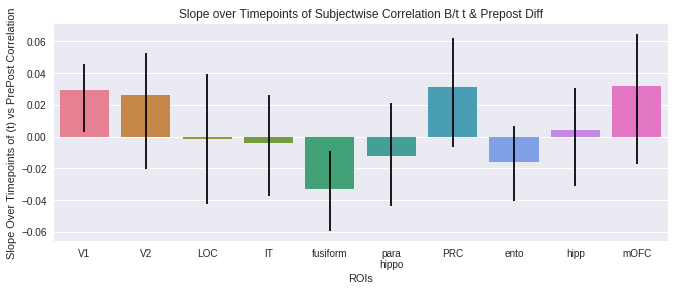

In [22]:
from scipy.stats import linregress

# second, instead of taking the overall mean draw_contrast score and relating that with differentiation, 
# get the draw_contrast score for each timepoint and relate those against differentiation
# the slope of all 20 or whatever correlations is what we graph

# define the estimator
def slope_contrastVSdiff(subdata):
    num_ivs = 20
    diffscores = [sub[1] for sub in subdata]
    correlations = []
    for i in range(num_ivs):
        clfscores = [np.mean(sub[0][0][i]) for sub in subdata]
        #clfscores = [np.mean(sub[0][0][i]-sub[0][1][i]) for sub in subdata]
        correlations.append(stats.pearsonr(clfscores, diffscores)[0])
    return linregress(np.arange(num_ivs),correlations)[0]

# derive from bardf the df we want to plot and the error bars we want
meandf = pd.DataFrame([slope_contrastVSdiff(np.array(bardf)[:,i]) for i in range(len(roi_list))]).transpose()
meandf.columns = roi_formatted
error = [bootstrapCI(np.array(bardf)[:,i],slope_contrastVSdiff, 1000)[1:3] for i in range(len(roi_list))]

plt.figure(figsize=(11,4))
sns.barplot(data=meandf,palette='husl',ci=None)
plt.xlabel('ROIs')
plt.title('Slope over Timepoints of Subjectwise Correlation B/t t & Prepost Diff')
plt.ylabel('Slope Over Timepoints of (t) vs PrePost Correlation')
for i in range(len(roi_list)):
    plt.vlines(i, error[i][0], error[i][1])
plt.show()

# Defunct

mean of binned cors

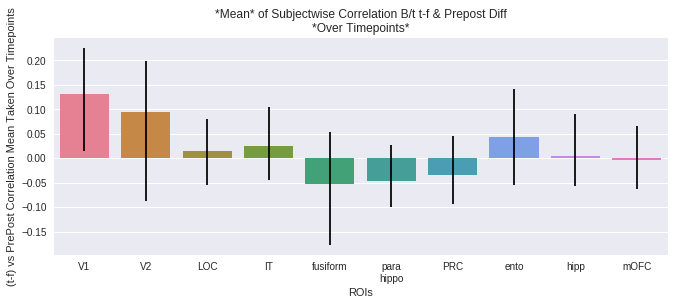

In [11]:
# second, instead of taking the overall mean draw_contrast score and relating that with differentiation, 
# get the draw_contrast score for each timepoint and relate those against differentiation
# the mean of all 20 or whatever correlations is what we graph

# define the estimator
def ivwise_contrastVSdiff(subdata):
    num_ivs = 20
    diffscores = [sub[1] for sub in subdata]
    correlations = []
    for i in range(num_ivs):
        clfscores = [np.mean(sub[0][0][i]) for sub in subdata]
        #clfscores = [np.mean(sub[0][0][i]-sub[0][1][i]) for sub in subdata]
        correlations.append(stats.pearsonr(clfscores, diffscores)[0])
    return np.mean(correlations)

# derive from bardf the df we want to plot and the error bars we want
meandf = pd.DataFrame([ivwise_contrastVSdiff(np.array(bardf)[:,i]) for i in range(len(roi_list))]).transpose()
meandf.columns = roi_formatted
error = [bootstrapCI(np.array(bardf)[:,i],ivwise_contrastVSdiff, 1000)[1:3] for i in range(len(roi_list))]

plt.figure(figsize=(11,4))
sns.barplot(data=meandf,palette='husl',ci=None)
plt.xlabel('ROIs')
plt.title('*Mean* of Subjectwise Correlation B/t t-f & Prepost Diff\n*Over Timepoints*')
plt.ylabel('(t-f) vs PrePost Correlation Mean Taken Over Timepoints')
for i in range(len(roi_list)):
    plt.vlines(i, error[i][0], error[i][1])
plt.show()

correlation of correlations

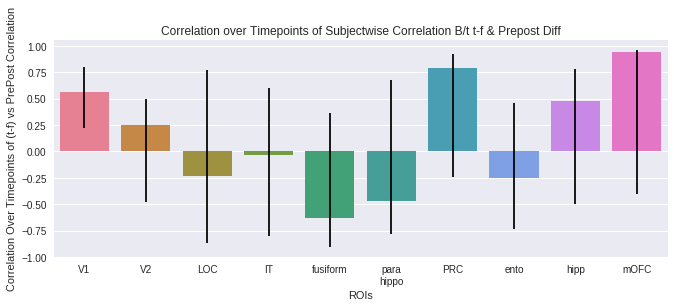

In [12]:
# second, instead of taking the overall mean draw_contrast score and relating that with differentiation, 
# get the draw_contrast score for each timepoint and relate those against differentiation
# the correlation of all 20 or whatever correlations is what we graph

# define the estimator
def cor_contrastVSdiff(subdata):
    num_ivs = 20
    diffscores = [sub[1] for sub in subdata]
    correlations = []
    for i in range(num_ivs):
        clfscores = [np.mean(sub[0][0][i]) for sub in subdata]
        #clfscores = [np.mean(sub[0][0][i]-sub[0][1][i]) for sub in subdata]
        correlations.append(stats.pearsonr(clfscores, diffscores)[0])
    return stats.pearsonr(np.arange(num_ivs),correlations)[0]

# derive from bardf the df we want to plot and the error bars we want
meandf = pd.DataFrame([cor_contrastVSdiff(np.array(bardf)[:,i]) for i in range(len(roi_list))]).transpose()
meandf.columns = roi_formatted
error = [bootstrapCI(np.array(bardf)[:,i],cor_contrastVSdiff, 1000)[1:3] for i in range(len(roi_list))]

plt.figure(figsize=(11,4))
sns.barplot(data=meandf,palette='husl',ci=None)
plt.xlabel('ROIs')
plt.title('Correlation over Timepoints of Subjectwise Correlation B/t t-f & Prepost Diff')
plt.ylabel('Correlation Over Timepoints of (t-f) vs PrePost Correlation')
for i in range(len(roi_list)):
    plt.vlines(i, error[i][0], error[i][1])
plt.show()